# Machine Problem: Treatment Efficacy Prediction Engine

## 1. Project Overview

**Objective:**
Develop a machine learning regression system that predicts a patient's **Improvement Score** (0-10) based on their demographic profile, medical condition, and prescribed treatment plan.

**The Problem:**
Doctors currently prescribe medication based on general guidelines. However, patient responses vary wildly. By predicting the "Improvement Score" *before* treatment begins, this tool aims to help physicians choose the most effective treatment plan (Drug + Dosage + Duration) for a specific individual, effectively creating a "Personalized Medicine" recommender.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load data
df = pd.read_csv("real_drug_dataset.csv")
df = df.drop(columns=['Patient_ID']) # Patient_ID has no particular use.

In [4]:
# Test if csv can be read successfully
df.head(10)

,Age,Gender,Condition,Drug_Name,Dosage_mg,Treatment_Duration_days,Side_Effects,Improvement_Score
0,56,Male,Infection,Ciprofloxacin,50,9,Nausea,8.5
1,69,Male,Hypertension,Metoprolol,500,24,Tiredness,8.7
2,46,Female,Depression,Bupropion,100,25,Dry mouth,5.4
3,32,Male,Diabetes,Glipizide,850,44,Low blood sugar,6.4
4,60,Male,Depression,Bupropion,850,35,Anxiety,5.3
5,25,Female,Infection,Ciprofloxacin,850,50,Dizziness,6.7
6,78,Male,Diabetes,Glipizide,250,40,Nausea,6.5
7,38,Male,Pain Relief,Paracetamol,100,15,Liver issues,8.2
8,56,Male,Depression,Escitalopram,850,56,Nausea,9.0
9,75,Male,Diabetes,Metformin,850,19,Nausea,9.1


### Phase 1: Exploratory Data Analysis (EDA)

1. **Univariate Analysis:** Plot histograms of `Improvement_Score`. Is it a Bell Curve (Normal Distribution) or skewed?

In [7]:
# Histogram


2. **Bivariate Analysis:**
* Does `Age` correlate with `Improvement_Score`? (Scatter plot).
* Do certain `Drugs` consistently perform better for certain `Conditions`? (Box plots).

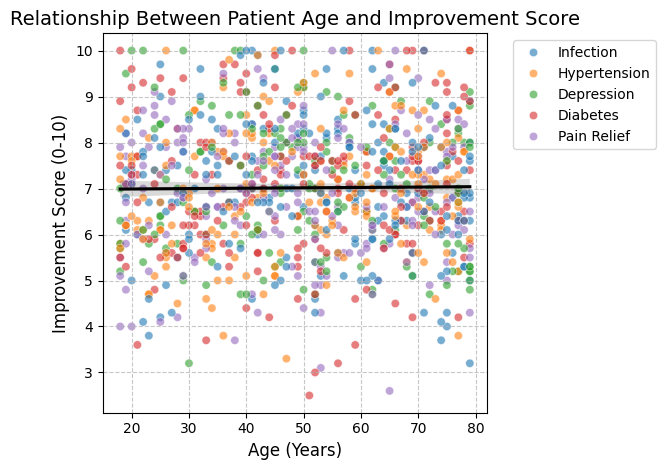

In [ ]:
# Scatter plot
sns.scatterplot(data=df, x='Age', y='Improvement_Score', hue='Condition', alpha=0.6)
sns.regplot(data=df, x='Age', y='Improvement_Score', scatter=False, color='black')  #Regression Line

# Scatter plot titles and labels
plt.title('Relationship Between Patient Age and Improvement Score', fontsize=14)
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel('Improvement Score (0-10)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Moves legend outside to keep plot clean
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

--------------------------------------------------------------------------------------------------------------------------------------
**Inference: Age vs. Improvement Score**

**Observation:**
Visual inspection of the scatter plot reveals **no discernible linear relationship** between a patient's Age and their Improvement Score.

1. **Visual Evidence:**
The data points are scattered uniformly across the chart without any clear upward or downward trend. The regression line (black line) is approximately horizontal, confirming a correlation coefficient near zero (`0.01`).
2. **Practical Implication:**
This suggests that **Age is not a strong standalone predictor** of treatment outcome in this dataset. A 20-year-old patient is just as likely to achieve a high improvement score (e.g., 9.0) as a 70-year-old patient.
3. **Modeling Note:**
While Age alone does not predict the score, it should not necessarily be discarded. It may still provide predictive power when **combined** with other features (e.g., *older patients might react differently to high dosages compared to younger patients*), which simpler univariate analysis cannot capture.
---------------------------------------------------------------------------------------------------------------------------------------



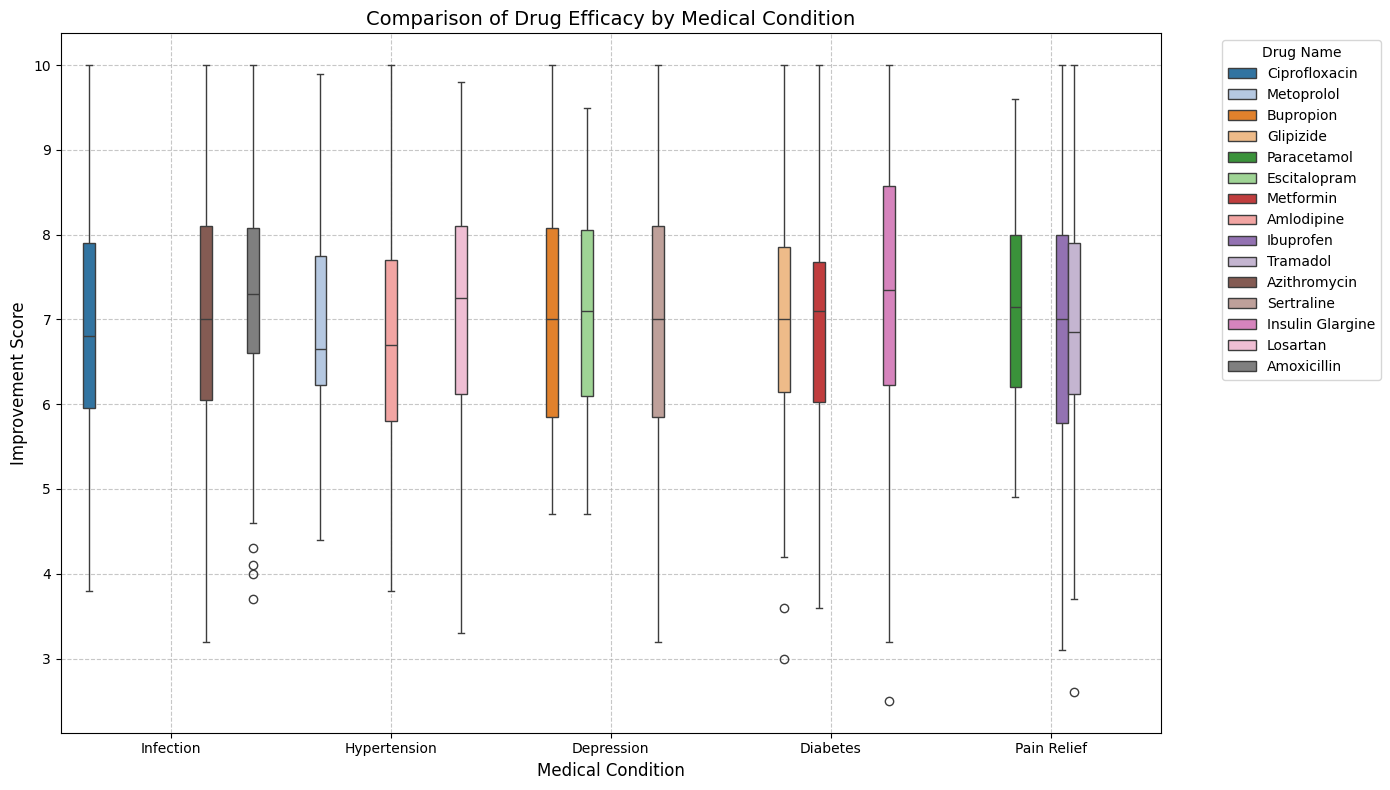

In [13]:
# Box plots
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='Condition', y='Improvement_Score', hue='Drug_Name', palette='tab20')

plt.title('Comparison of Drug Efficacy by Medical Condition', fontsize=14)
plt.xlabel('Medical Condition', fontsize=12)
plt.ylabel('Improvement Score', fontsize=12)
plt.legend(title='Drug Name', bbox_to_anchor=(1.05, 1), loc='upper left') # Moves legend outside to keep plot clean
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

--------------------------------------------------------------------------------------------------------------------------------------
**Inference: Drug Efficacy by Medical Condition**

**Observation:**
Visual inspection of the box plot reveals that while some drugs perform better on average, there is significant overlap in effectiveness across treatments for the same condition.

1. **Visual Evidence:**
* **The "Winners":** Certain drugs show higher median lines (the line inside the box). For example, **Insulin Glargine** (Diabetes) and **Losartan** (Hypertension) appear to have the highest median improvement scores (~7.3).
* **The "Risky" Options:** Drugs like **Sertraline** (Depression) display very "tall" boxes with long whiskers. This indicates high variance—meaning the drug works amazingly for some (score 10) but poorly for others (score < 4).
* **The "Reliable" Options:** Drugs like **Metoprolol** (Hypertension) have shorter boxes, suggesting they produce consistent, predictable results, even if they aren't always the highest scorers.


2. **Practical Implication:**
This suggests that a **"one-size-fits-all" prescription strategy is suboptimal**. Since no single drug guarantees a high score for every patient, doctors cannot rely solely on the "average" best drug; they must consider individual patient characteristics.
3. **Modeling Note:**
The high variance (tall boxes) confirms that **Condition and Drug Name alone are not enough** to predict the outcome perfectly. The machine learning model will need to leverage other features (like *Age, Dosage, or Gender*) to determine *which* specific patients will fall into the high-success range of a volatile drug like Insulin Glargine.

---------------------------------------------------------------------------------------------------------------------------------------

3. **Correlation Matrix:** Use a Heatmap to see if `Dosage` and `Duration` are correlated.

In [9]:
# Heatmap 

---

### Phase 2: Data Preprocessing & Feature Engineering
1. **Encoding:** Convert `Gender`, `Condition`, and `Drug_Name` into numbers using **One-Hot Encoding** (`pd.get_dummies`).

In [21]:
# Get all the values and its distribution for Gender, Condition, and Drug Name
print(df.Gender.value_counts().sort_index())
print(df.Condition.value_counts().sort_index())
print(df.Drug_Name.value_counts().sort_index())

Gender
Female    477
Male      523
Name: count, dtype: int64
Condition
Depression      176
Diabetes        207
Hypertension    194
Infection       215
Pain Relief     208
Name: count, dtype: int64
Drug_Name
Amlodipine          74
Amoxicillin         66
Azithromycin        70
Bupropion           66
Ciprofloxacin       79
Escitalopram        55
Glipizide           67
Ibuprofen           64
Insulin Glargine    78
Losartan            66
Metformin           62
Metoprolol          54
Paracetamol         62
Sertraline          55
Tramadol            82
Name: count, dtype: int64


In [ ]:
# One hot encoding
print(f"Original Data:\n{df}\n")

df_encoded = pd.get_dummies(df, columns=['Gender', 'Condition', 'Drug_Name'], drop_first=True)
print(f"One-Hot Encoded Data using Pandas:\n{df_encoded}\n")

Original Data:
     Age  Gender     Condition      Drug_Name  Dosage_mg  \
0     56    Male     Infection  Ciprofloxacin         50   
1     69    Male  Hypertension     Metoprolol        500   
2     46  Female    Depression      Bupropion        100   
3     32    Male      Diabetes      Glipizide        850   
4     60    Male    Depression      Bupropion        850   
..   ...     ...           ...            ...        ...   
995   18    Male  Hypertension       Losartan        100   
996   35  Female     Infection   Azithromycin         50   
997   49  Female    Depression     Sertraline        850   
998   64    Male    Depression   Escitalopram        850   
999   66  Female  Hypertension     Metoprolol        500   

     Treatment_Duration_days     Side_Effects  Improvement_Score  
0                          9           Nausea                8.5  
1                         24        Tiredness                8.7  
2                         25        Dry mouth                5.

2. **Scaling:** Normalize `Dosage_mg` and `Age` using **MinMax Scaler** or **Standard Scaler** so large numbers don't confuse the model.

In [ ]:
# Code

3. **Feature Engineering (The "Secret Sauce"):**
* Create a new feature: `Total_Drug_Exposure = Dosage_mg * Treatment_Duration_days`.
* Create an interaction feature: `Age_Group` (e.g., Young, Middle, Senior).

In [ ]:
# Code


---

### Phase 3: Model Development
1. **Baseline Model:** Train a simple **Linear Regression**. Calculate the R2 Score. (Note: It will likely be low/poor. This is your baseline to beat).

In [ ]:
# Linear Regression 


2. **Advanced Model 1:** Train a **Decision Tree Regressor**. This handles non-linear data better (e.g., maybe high dosage is good for young people but bad for old people).

In [ ]:
# Decision Trree Regressor


3. **Advanced Model 2 (Champion):** Train a **Random Forest Regressor** or **Gradient Boosting Regressor**. These combine many trees to reduce errors.

In [ ]:
# Random Forest


# Gradient Boosting



---

### Phase 4: Evaluation & Interpretation

1. **Metrics:** Report **MAE** (Mean Absolute Error) and **RMSE** (Root Mean Squared Error).
2. **Feature Importance:** Extract which factors mattered most. Was it the *Drug Name* or the *Duration*? 

*Lorem ipsum dolor sit amet, consectetur adipiscing elit. Maecenas congue quam vitae pretium aliquam. Sed fermentum blandit est, fringilla ultricies ligula venenatis id. Suspendisse pretium quam sed nibh lacinia mattis sit amet vitae dui. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Proin in pharetra orci. Donec at placerat elit. Duis tristique mollis tristique. Nam eu leo efficitur, fermentum nibh at, tincidunt tortor. Pellentesque id quam tortor. Duis velit libero, sagittis rutrum lectus in, aliquet pharetra magna. In pharetra mollis sagittis. Sed malesuada quam lorem. Nam dictum magna vel tellus ornare, nec sodales erat pulvinar. Curabitur volutpat, lacus tincidunt bibendum pharetra, erat diam semper diam, id venenatis metus est non magna. Etiam vehicula sollicitudin hendrerit. Nullam porttitor dui at sem euismod blandit.*